In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/Project/results')

In [3]:
import os, re, glob, json
from typing import Dict, Any, Optional, List, Set, Union
import pandas as pd

INPUT_DIR    = "./"                     # change to your folder
OUTPUT_CSV   = "model_style_performance.csv"
ROUND_DIGITS = 2
ENFORCE_STYLES = True
VERBOSE_LOG  = True

DEFAULT_STYLE_ORDER = ["children", "gen-z", "gen x", "gen-x", "millennial", "academic"]
LIKELY_STYLE_KEYS   = ["per_style", "style_stats", "per_style_stats", "style_breakdown", "styles"]
LIKELY_TOP_LEVELS   = ["", "meta", "metrics", "results", "summary"]

def parse_model_from_filename(path: str) -> str:
    fname = os.path.basename(path)
    m = re.search(r"results(?:_task)?_(.+?)_id_", fname)
    model_raw = m.group(1) if m else os.path.splitext(fname)[0]
    return model_raw.replace("__", " ").replace("_", " ").strip()

def to_percent(val: Any) -> Optional[float]:
    try:
        f = float(val)
    except Exception:
        return None
    return f * 100.0 if 0.0 <= f <= 1.0 else f

def _extract_overall_from_dict(obj: Dict[str, Any]) -> Optional[float]:
    for k in ["overall", "accuracy", "acc", "overall_accuracy", "score"]:
        if k in obj:
            p = to_percent(obj[k])
            if p is not None:
                return p
    correct = None
    total = None
    for k in ["correct", "n_correct", "hits"]:
        if k in obj:
            correct = obj[k]
            break
    for k in ["total", "n_total", "count", "questions", "num_examples"]:
        if k in obj:
            total = obj[k]
            break
    try:
        if correct is not None and total:
            return (float(correct) / float(total)) * 100.0
    except Exception:
        pass
    for parent in ["metrics", "results", "summary", "meta"]:
        child = obj.get(parent)
        if isinstance(child, dict):
            res = _extract_overall_from_dict(child)
            if res is not None:
                return res
        elif isinstance(child, list):
            for item in child:
                if isinstance(item, dict):
                    res = _extract_overall_from_dict(item)
                    if res is not None:
                        return res
    return None

def extract_overall_percentage(data: Union[Dict[str, Any], List[Any]]) -> Optional[float]:
    if isinstance(data, dict):
        return _extract_overall_from_dict(data)
    if isinstance(data, list):
        for item in data:
            if isinstance(item, dict):
                res = _extract_overall_from_dict(item)
                if res is not None:
                    return res
    return None

def _add_candidate_dict(d: Dict[str, Any], out: Dict[str, float]):
    for k, v in d.items():
        if isinstance(v, dict):
            lower = {kk.lower(): vv for kk, vv in v.items()}
            for key in ["percent", "percentage", "pct", "accuracy", "acc"]:
                if key in lower:
                    p = to_percent(lower[key])
                    if p is not None:
                        out[k] = p
                        break
            else:
                correct = lower.get("correct") or lower.get("num_correct") or lower.get("hits")
                total   = lower.get("total") or lower.get("n") or lower.get("count")
                try:
                    if correct is not None and total:
                        out[k] = (float(correct) / float(total)) * 100.0
                except Exception:
                    pass
        else:
            p = to_percent(v)
            if p is not None:
                out[k] = p

def extract_style_stats(data: Union[Dict[str, Any], List[Any]]) -> Dict[str, float]:
    style_acc: Dict[str, float] = {}
    def scan_container(container: Any):
        if isinstance(container, dict):
            for key in LIKELY_STYLE_KEYS:
                val = container.get(key)
                if isinstance(val, dict):
                    _add_candidate_dict(val, style_acc)
                elif isinstance(val, list):
                    for item in val:
                        if isinstance(item, dict):
                            _add_candidate_dict(item, style_acc)
    if isinstance(data, dict):
        for parent in LIKELY_TOP_LEVELS:
            container = data if parent == "" else data.get(parent)
            scan_container(container)
    elif isinstance(data, list):
        for item in data:
            if isinstance(item, dict):
                for parent in LIKELY_TOP_LEVELS:
                    container = item if parent == "" else item.get(parent)
                    scan_container(container)
    return style_acc

def normalize_style_name(name: str) -> str:
    s = name.strip().lower()
    s = s.replace("_", "-").replace("–", "-")
    s = re.sub(r"\s+", " ", s)
    s = s.replace("gen x", "gen-x")
    return s

def coerce_top_level_to_dict(data: Union[Dict[str, Any], List[Any]]) -> Optional[Dict[str, Any]]:
    if isinstance(data, dict):
        return data
    if isinstance(data, list):
        for item in data:
            if isinstance(item, dict) and any(k in item for k in ["model", "model_name", "metrics", "results", "summary", "meta"]):
                return item
        merged = {}
        for item in data:
            if isinstance(item, dict):
                merged.update(item)
        return merged or None
    return None

def aggregate_json_dir(input_dir: str, round_digits: int = 2, enforce_styles: bool = True) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(input_dir, "*.json")))
    rows: List[Dict[str, Any]] = []
    all_styles: Set[str] = set()
    loaded, skipped = 0, 0

    for f in files:
        try:
            with open(f, "r", encoding="utf-8") as fh:
                raw = json.load(fh)
        except Exception as e:
            skipped += 1
            if VERBOSE_LOG:
                print(f"[skip] {os.path.basename(f)} — not a readable JSON ({e})")
            continue

        data_for_id = coerce_top_level_to_dict(raw)
        if data_for_id is None:
            skipped += 1
            if VERBOSE_LOG:
                print(f"[skip] {os.path.basename(f)} — JSON has no usable dict content")
            continue

        model = data_for_id.get("model_name") or data_for_id.get("model") or parse_model_from_filename(f)
        overall_pct = extract_overall_percentage(raw)
        style_pct_raw = extract_style_stats(raw)
        style_pct = {normalize_style_name(k): v for k, v in style_pct_raw.items()}
        all_styles.update(style_pct.keys())

        row = {"model": model}
        if overall_pct is not None:
            row["overall_%"] = round(overall_pct, round_digits)
        for k, v in style_pct.items():
            row[k] = round(v, round_digits)
        rows.append(row)
        loaded += 1
        if VERBOSE_LOG:
            print(f"[ok]   {os.path.basename(f)}")

    if VERBOSE_LOG:
        print(f"\nLoaded {loaded} files, skipped {skipped} files.")

    if not rows:
        return pd.DataFrame(columns=["model", "overall_%"])

    if enforce_styles:
        baseline = [normalize_style_name(s) for s in DEFAULT_STYLE_ORDER]
        extras = sorted(list(all_styles - set(baseline)))
        style_cols = baseline + extras
    else:
        style_cols = sorted(all_styles)

    columns = ["model", "overall_%"] + style_cols
    df = pd.DataFrame(rows)
    for c in columns:
        if c not in df.columns:
            df[c] = None
    df = df[columns].sort_values("model").reset_index(drop=True)

    # if OUTPUT_CSV:
    #     df.to_csv(OUTPUT_CSV, index=False)
    #     print(f"Saved CSV -> {OUTPUT_CSV}")

    display(df)
    return df

# Run it
df = aggregate_json_dir(INPUT_DIR, ROUND_DIGITS, ENFORCE_STYLES)


[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_academic_20250815_105450.json
[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_boomer_20250815_110017.json
[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_children_20250815_105547.json
[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_gen_alpha_20250815_105642.json
[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_gen_x_20250815_105924.json
[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_gen_z_20250815_105737.json
[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_id_20250815_105353.json
[ok]   results_task_MoritzLaurer_DeBERTa-v3-large-mnli-fever-anli-ling-wanli_millennial_20250815_105832.json
[ok]   results_task_facebook_bart-large-mnli_academic_20250816_132850.json
[ok]   results_task_facebook_bart-large-mnli_boomer_20250816_141812.json
[ok]   

,model,overall_%,children,gen-z,gen-x,gen-x,millennial,academic
0,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,25.2,None,None,None,None,None,None
1,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,25.4,None,None,None,None,None,None
2,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,26.6,None,None,None,None,None,None
3,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,21.4,None,None,None,None,None,None
4,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,24.8,None,None,None,None,None,None
5,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,24.0,None,None,None,None,None,None
6,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,25.8,None,None,None,None,None,None
7,MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...,26.4,None,None,None,None,None,None
8,facebook/bart-large-mnli,0.0,None,None,None,None,None,None
9,facebook/bart-large-mnli,25.2,None,None,None,None,None,None



Loaded 32 files; skipped 0.


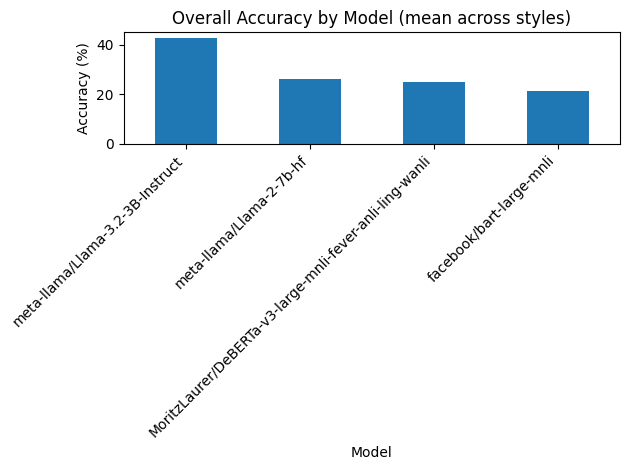

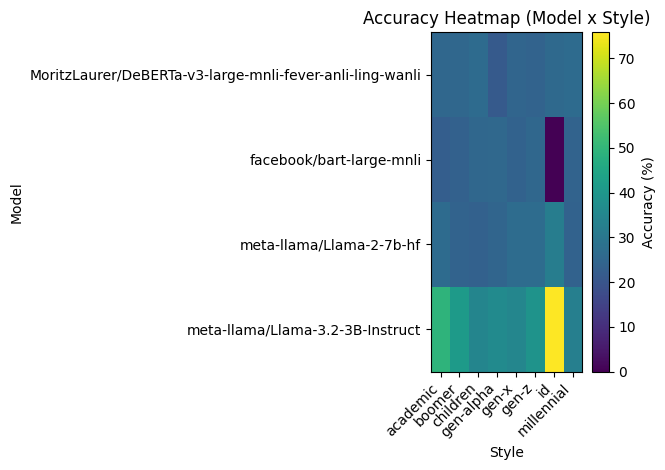

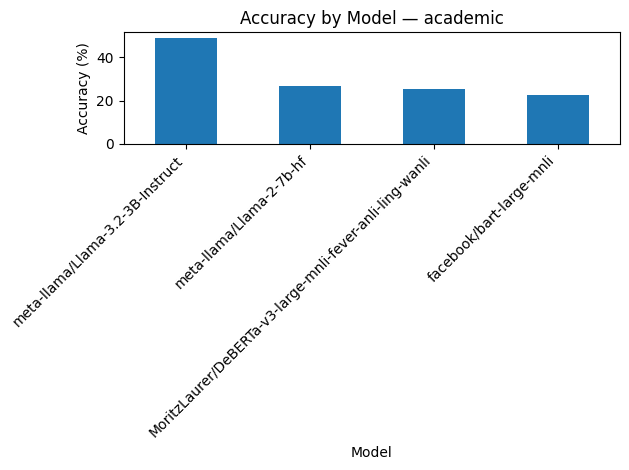

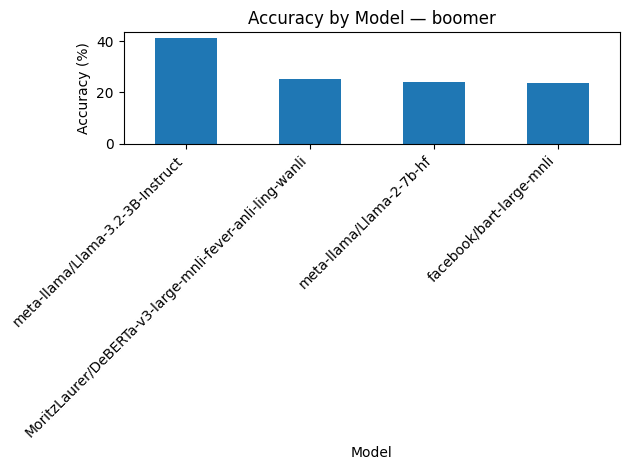

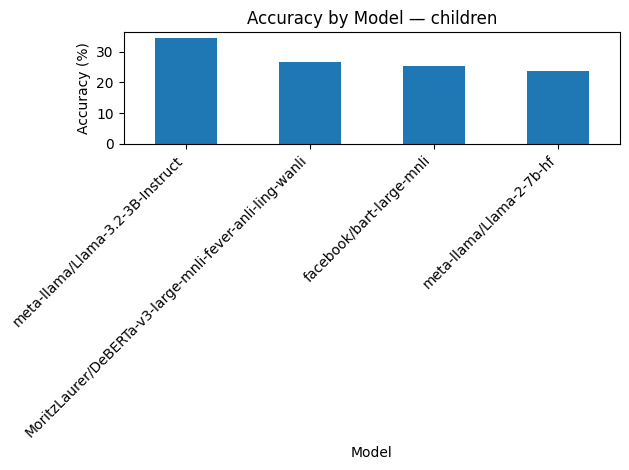

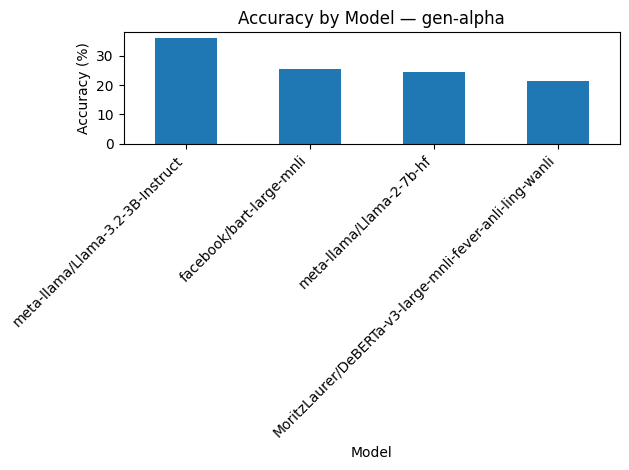

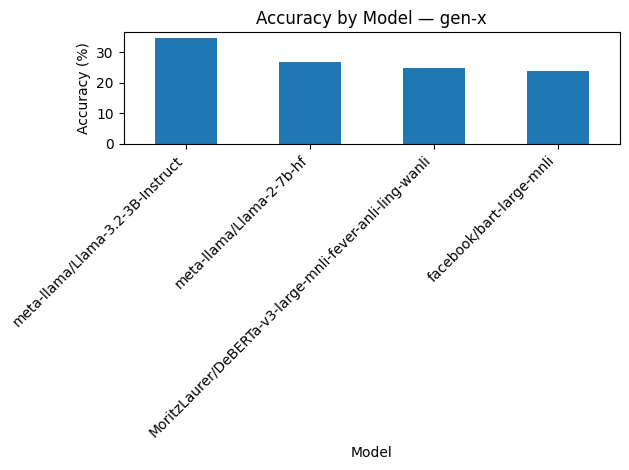

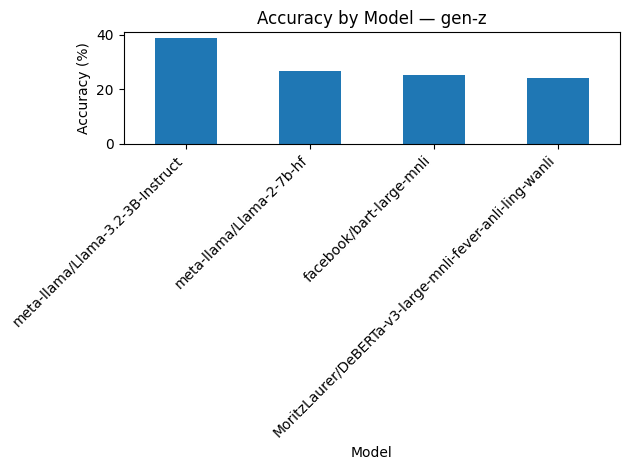

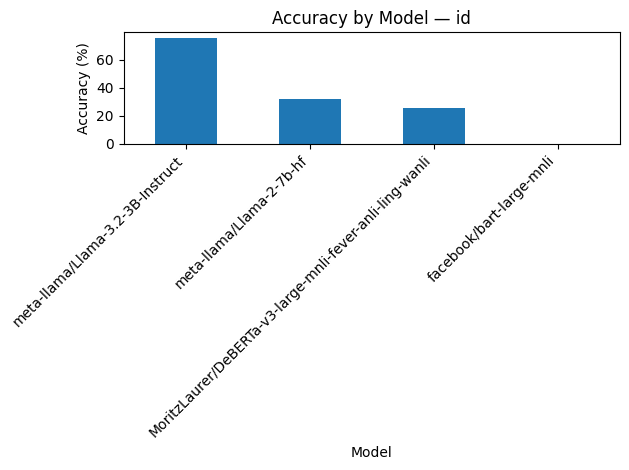

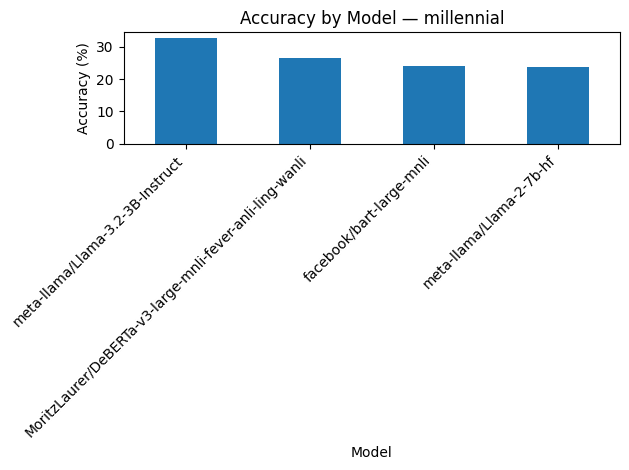

In [4]:
# Simple, opinionated notebook cell per your constraints:
# - Reads all JSONs from INPUT_DIR
# - Model name taken from JSON (keys: model/model_name)
# - Writing style parsed from the JSON *filename*
# - Accuracy taken from JSON (accuracy/acc/overall/score or percent/percentage or correct/total)
# - Builds a tidy DataFrame, a pivot (models x styles), saves CSV
# - Plots: (1) Overall accuracy by model, (2) Style-wise accuracy heatmap, (3) Per-style bars for quick comparison
#
# Notes:
# - Uses matplotlib only, one chart per figure, no explicit colors/styles set.

import os, re, glob, json
from typing import Any, Dict, Optional, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- settings --------
INPUT_DIR = ""   # change if needed
OUTPUT_CSV = "model_style_summary_simple.csv"

# Define the set of known styles we expect to find in filenames
STYLE_ALIASES = {
    "children": ["children", "child", "kids"],
    "gen-z": ["gen-z", "genz", "gen_z", "gen z", "z"],
    "gen-x": ["gen-x", "genx", "gen_x", "gen x", "x"],
    "millennial": ["millennial", "millenial", "millennials"],
    "academic": ["academic", "acad"],
    "original": ["original", "orig", "base"],
    "boomer": ["boomer", "boomers"],
    "gen-alpha": ["gen-alpha", "genalpha", "gen_alpha", "gen alpha", "alpha"],
    "id": ["id"]  # if 'id' is a valid style tag
}

def normalize_style_from_filename(fname: str) -> Optional[str]:
    name = os.path.basename(fname).lower()
    name = re.sub(r"\.[^.]+$", "", name)  # strip extension
    name = name.replace("-", " ").replace("_", " ")
    # Try exact alias match
    for norm, variants in STYLE_ALIASES.items():
        for v in variants:
            if re.search(rf"\b{re.escape(v)}\b", name):
                return norm
    # Fallback: try picking any token that looks like a style tag
    # (alpha tokens of length >= 3)
    tokens = [t for t in re.split(r"\W+", name) if t]
    # If nothing matched, return None; user asked for style from name, so better to be explicit
    return None

def to_percent(val: Any) -> Optional[float]:
    try:
        f = float(val)
    except Exception:
        return None
    # If looks like 0..1, treat as accuracy
    if 0.0 <= f <= 1.0:
        return f * 100.0
    return f

def extract_model_and_accuracy(obj: Dict[str, Any]):
    # model
    model = obj.get("model") or obj.get("model_name")
    # accuracy-like fields
    for k in ["accuracy", "acc", "overall", "score", "percent", "percentage"]:
        if k in obj:
            p = to_percent(obj[k])
            if p is not None:
                return model, p
    # correct / total
    correct = obj.get("correct")
    total = obj.get("total") or obj.get("count") or obj.get("n_total") or obj.get("questions")
    if correct is not None and total:
        try:
            return model, (float(correct)/float(total))*100.0
        except Exception:
            pass
    # May be nested one level under "metrics"/"results"/"summary"
    for parent in ["metrics", "results", "summary"]:
        child = obj.get(parent)
        if isinstance(child, dict):
            m, p = extract_model_and_accuracy(child)
            if m or p is not None:
                return model or m, p
    return model, None

# -------- load files --------
records: List[Dict[str, Any]] = []
loaded, skipped = 0, 0

for path in sorted(glob.glob(os.path.join(INPUT_DIR, "*.json"))):
    style = normalize_style_from_filename(path)
    try:
        with open(path, "r", encoding="utf-8") as fh:
            data = json.load(fh)
    except Exception as e:
        skipped += 1
        print(f"[skip] {os.path.basename(path)}: not valid JSON ({e})")
        continue

    # Expecting a dict per your note. If it's a list, take first dict.
    if isinstance(data, list):
        data = next((x for x in data if isinstance(x, dict)), {})

    if not isinstance(data, dict):
        skipped += 1
        print(f"[skip] {os.path.basename(path)}: JSON not an object")
        continue

    model, pct = extract_model_and_accuracy(data)

    # Only accept rows where we can identify both model and style (per your constraints)
    if model and style and (pct is not None):
        records.append({
            "file": os.path.basename(path),
            "model": model,
            "style": style,
            "accuracy_%": float(pct)
        })
        loaded += 1
    else:
        skipped += 1
        why = []
        if not model: why.append("no model in JSON")
        if not style: why.append("no style in filename")
        if pct is None: why.append("no accuracy in JSON")
        print(f"[skip] {os.path.basename(path)}: " + ", ".join(why))

print(f"\nLoaded {loaded} files; skipped {skipped}.")

if not records:
    print("No usable records. Please check file names (must contain a style tag) and JSON keys (model, accuracy).")
else:
    df = pd.DataFrame(records)
    # Save and show raw long-form data
    # df.to_csv(OUTPUT_CSV, index=False)
    # print(f"Saved CSV -> {OUTPUT_CSV}")

    # Pivot: rows=models, cols=styles
    pivot = df.pivot_table(index="model", columns="style", values="accuracy_%", aggfunc="mean")
    pivot = pivot.reindex(sorted(pivot.index), axis=0)  # sort models
    # Show pivot to user as well

    # Compute overall per model as mean across styles present
    overall = pivot.mean(axis=1).sort_values(ascending=False)

    # --------- Charts ---------
    # 1) Overall accuracy by model (bar)
    plt.figure()
    overall.plot(kind="bar")
    plt.title("Overall Accuracy by Model (mean across styles)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 2) Heatmap of style-wise accuracy (models x styles)
    if pivot.shape[0] > 0 and pivot.shape[1] > 0:
        plt.figure()
        # Using imshow for a simple heatmap; NaNs will appear blank
        arr = pivot.to_numpy()
        plt.imshow(arr, aspect="auto", interpolation="nearest")
        plt.title("Accuracy Heatmap (Model x Style)")
        plt.ylabel("Model")
        plt.xlabel("Style")
        plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
        plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns, rotation=45, ha="right")
        plt.colorbar(label="Accuracy (%)")
        plt.tight_layout()
        plt.show()

    # 3) Per-style bar charts: for each style, accuracy by model
    for style_name in pivot.columns:
        series = pivot[style_name].dropna().sort_values(ascending=False)
        if len(series) == 0:
            continue
        plt.figure()
        series.plot(kind="bar")
        plt.title(f"Accuracy by Model — {style_name}")
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Model")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()



Loaded 32 files; skipped 0.

Top 5 easiest styles (highest mean accuracy):
  id: 33.40
  academic: 30.90
  gen-z: 28.75
  boomer: 28.65
  gen-x: 27.55

Top 5 most volatile styles (highest std across models):
  id: 31.48
  academic: 12.31
  boomer: 8.53
  gen-z: 6.93
  gen-alpha: 6.42

Most robust models (lowest std across styles):
model
MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli     1.662184
meta-llama/Llama-2-7b-hf                                     2.762504
facebook/bart-large-mnli                                     8.644569
meta-llama/Llama-3.2-3B-Instruct                            14.247381
dtype: float64

Smallest spread across styles (min range):
model
MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli     5.2
meta-llama/Llama-2-7b-hf                                     8.4
facebook/bart-large-mnli                                    25.6
meta-llama/Llama-3.2-3B-Instruct                            43.0
dtype: float64


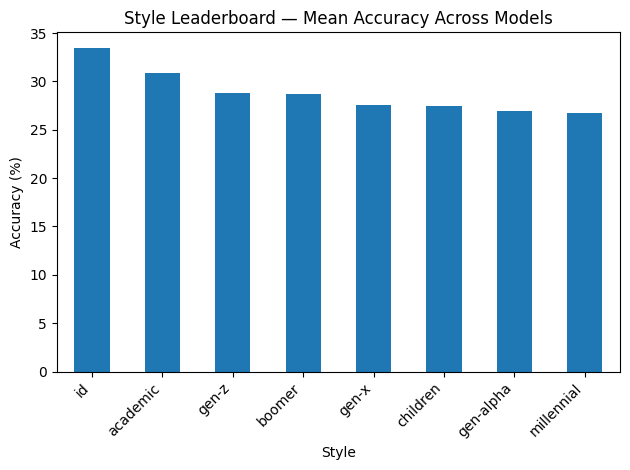

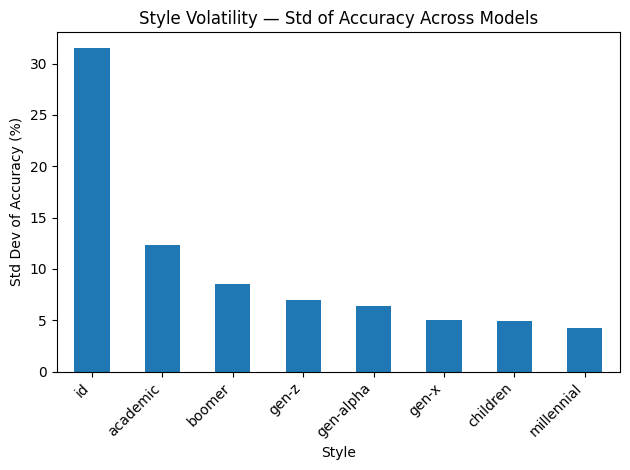

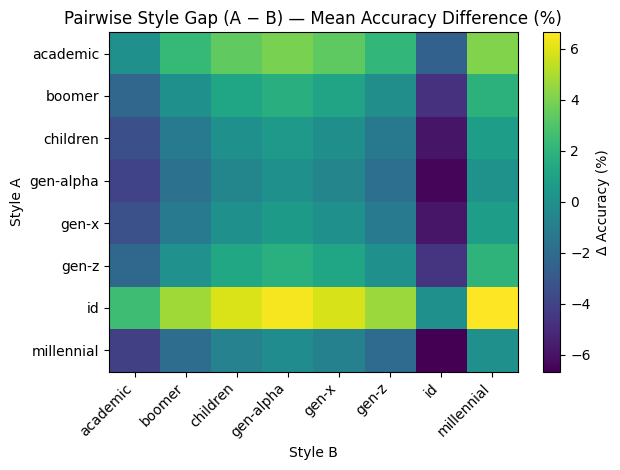

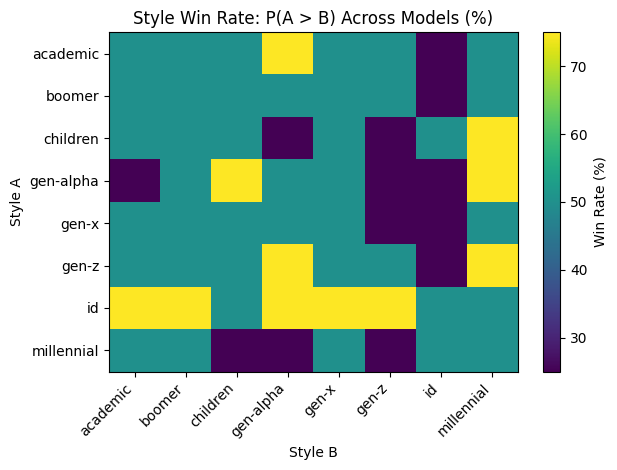

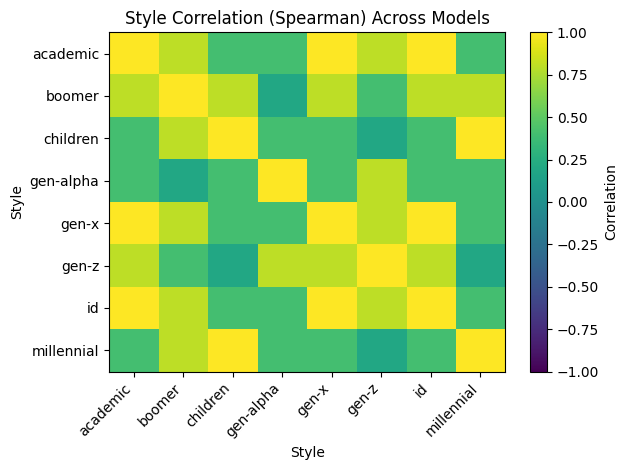

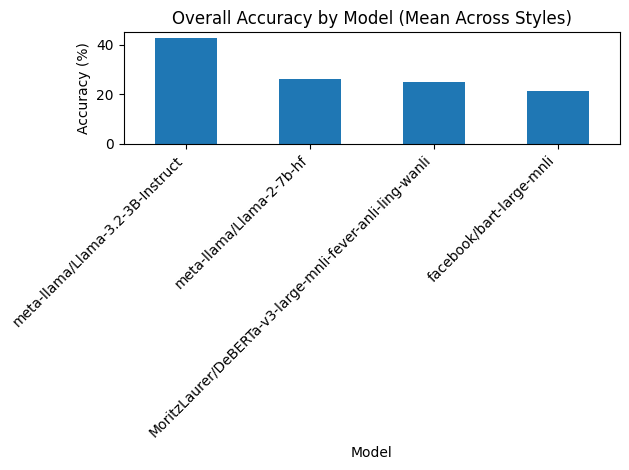

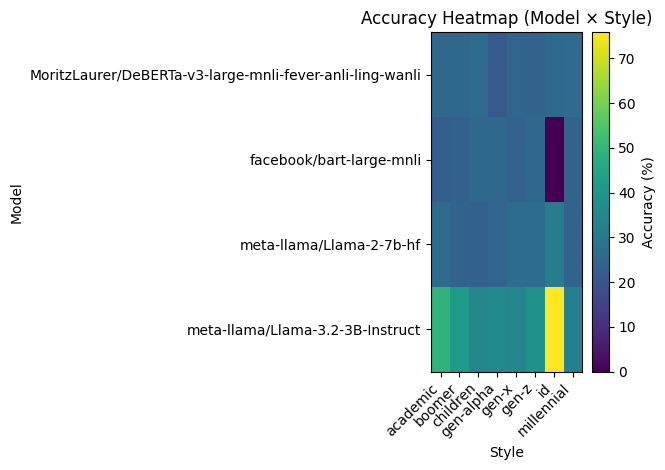

In [5]:
# --- One-cell style-centric analysis pipeline (matplotlib only; one chart per figure; no explicit colors) ---

import os, re, glob, json
from typing import Any, Dict, Optional, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Settings
# =========================
INPUT_DIR = ""   # <-- set your folder with *.json results
OUTPUT_CSV = "model_style_summary_simple.csv"

STYLE_ALIASES = {
    "children":   ["children", "child", "kids"],
    "gen-z":      ["gen-z", "genz", "gen_z", "gen z", "z"],
    "gen-x":      ["gen-x", "genx", "gen_x", "gen x", "x"],
    "millennial": ["millennial", "millenial", "millennials"],
    "academic":   ["academic", "acad"],
    "original":   ["original", "orig", "base"],
    "boomer":     ["boomer", "boomers"],
    "gen-alpha":  ["gen-alpha", "genalpha", "gen_alpha", "gen alpha", "alpha"],
    "id":         ["id"]  # keep only if "id" truly denotes a style
}

# =========================
# Helpers
# =========================
def normalize_style_from_filename(fname: str) -> Optional[str]:
    name = os.path.basename(fname).lower()
    name = re.sub(r"\.[^.]+$", "", name)  # strip extension
    name = name.replace("-", " ").replace("_", " ")
    for norm, variants in STYLE_ALIASES.items():
        for v in variants:
            if re.search(rf"\b{re.escape(v)}\b", name):
                return norm
    return None

def to_percent(val: Any) -> Optional[float]:
    try:
        f = float(val)
    except Exception:
        return None
    if 0.0 <= f <= 1.0:
        return f * 100.0
    return f

def extract_model_and_accuracy(obj: Dict[str, Any]):
    # Try shallow keys
    model = obj.get("model") or obj.get("model_name")
    for k in ["accuracy", "acc", "overall", "score", "percent", "percentage"]:
        if k in obj:
            p = to_percent(obj[k])
            if p is not None:
                return model, p
    # correct/total
    correct = obj.get("correct")
    total = obj.get("total") or obj.get("count") or obj.get("n_total") or obj.get("questions")
    if correct is not None and total:
        try:
            return model, (float(correct) / float(total)) * 100.0
        except Exception:
            pass
    # look one level deep
    for parent in ["metrics", "results", "summary"]:
        child = obj.get(parent)
        if isinstance(child, dict):
            m, p = extract_model_and_accuracy(child)
            if m or p is not None:
                return model or m, p
    return model, None

# =========================
# Load files
# =========================
records: List[Dict[str, Any]] = []
loaded, skipped = 0, 0

for path in sorted(glob.glob(os.path.join(INPUT_DIR, "*.json"))):
    style = normalize_style_from_filename(path)
    try:
        with open(path, "r", encoding="utf-8") as fh:
            data = json.load(fh)
    except Exception as e:
        skipped += 1
        print(f"[skip] {os.path.basename(path)}: not valid JSON ({e})")
        continue

    if isinstance(data, list):
        data = next((x for x in data if isinstance(x, dict)), {})

    if not isinstance(data, dict):
        skipped += 1
        print(f"[skip] {os.path.basename(path)}: JSON not an object")
        continue

    model, pct = extract_model_and_accuracy(data)

    if model and style and (pct is not None):
        records.append({
            "file": os.path.basename(path),
            "model": str(model),
            "style": style,
            "accuracy_%": float(pct)
        })
        loaded += 1
    else:
        skipped += 1
        why = []
        if not model: why.append("no model in JSON")
        if not style: why.append("no style in filename")
        if pct is None: why.append("no accuracy in JSON")
        print(f"[skip] {os.path.basename(path)}: " + ", ".join(why))

print(f"\nLoaded {loaded} files; skipped {skipped}.")

if not records:
    print("No usable records. Please check file names (must contain a style tag) and JSON keys (model, accuracy).")

else:
    # =========================
    # Base tables
    # =========================
    df = pd.DataFrame(records)
    # df.to_csv(OUTPUT_CSV, index=False)
    # print(f"Saved CSV -> {OUTPUT_CSV}")

    pivot = df.pivot_table(index="model", columns="style", values="accuracy_%", aggfunc="mean")
    pivot = pivot.sort_index()

    # =========================
    # Style-focused summaries
    # =========================
    style_mean  = pivot.mean(axis=0).sort_values(ascending=False)
    style_std   = pivot.std(axis=0).sort_values(ascending=False)
    style_count = pivot.count(axis=0)

    # Model robustness to style
    model_std   = pivot.std(axis=1).sort_values(ascending=True)         # lower = more robust
    model_range = (pivot.max(axis=1) - pivot.min(axis=1)).sort_values(ascending=True)

    # Pairwise style gap (A - B) and win-rate matrices (safe scalar assignment)
    styles = list(pivot.columns)
    gap = pd.DataFrame(index=styles, columns=styles, dtype=float)
    winrate = pd.DataFrame(index=styles, columns=styles, dtype=float)

    for a in styles:
        for b in styles:
            if a == b:
                gap.loc[a, b] = 0.0
                winrate.loc[a, b] = 50.0
                continue

            common = pivot[[a, b]].dropna()
            if common.empty:
                gap.loc[a, b] = np.nan
                winrate.loc[a, b] = np.nan
                continue

            diff = common[a].to_numpy() - common[b].to_numpy()
            gap.loc[a, b] = float(np.nanmean(diff))
            winrate.loc[a, b] = float((diff > 0).mean() * 100.0)

    # Style correlation across models (Spearman)
    style_corr = pivot.corr(method="spearman")

    # Best/Worst style per model
    best_worst = []
    for m, row in pivot.iterrows():
        row_drop = row.dropna()
        if len(row_drop) == 0:
            continue
        best = row_drop.idxmax()
        worst = row_drop.idxmin()
        best_worst.append({
            "model": m,
            "best_style": best,
            "best_acc_%": float(row_drop[best]),
            "worst_style": worst,
            "worst_acc_%": float(row_drop[worst]),
            "range_%": float(row_drop[best] - row_drop[worst]),
        })
    best_worst_df = pd.DataFrame(best_worst).sort_values("range_%", ascending=False)
    # best_worst_df.to_csv("best_worst_style_per_model.csv", index=False)
    # print("Saved CSV -> best_worst_style_per_model.csv")

    # =========================
    # Quick textual insights
    # =========================
    def top_n(s: pd.Series, n=3, title=""):
        n = min(n, len(s))
        if n == 0: return
        print(f"\nTop {n} {title}:")
        for k, v in s.head(n).items():
            print(f"  {k}: {v:.2f}")

    top_n(style_mean, 5, "easiest styles (highest mean accuracy)")
    top_n(style_std, 5, "most volatile styles (highest std across models)")

    print("\nMost robust models (lowest std across styles):")
    print(model_std.head(min(5, len(model_std))))

    print("\nSmallest spread across styles (min range):")
    print(model_range.head(min(5, len(model_range))))

    # =========================
    # Plots (no explicit colors; one chart per figure)
    # =========================
    # A) Style leaderboard
    plt.figure()
    style_mean.plot(kind="bar")
    plt.title("Style Leaderboard — Mean Accuracy Across Models")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Style")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # B) Style volatility
    plt.figure()
    style_std.plot(kind="bar")
    plt.title("Style Volatility — Std of Accuracy Across Models")
    plt.ylabel("Std Dev of Accuracy (%)")
    plt.xlabel("Style")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # C) Pairwise style gap heatmap (A − B)
    if gap.shape[0] > 0 and gap.shape[1] > 0:
        plt.figure()
        plt.imshow(gap.to_numpy(), aspect="auto", interpolation="nearest")
        plt.title("Pairwise Style Gap (A − B) — Mean Accuracy Difference (%)")
        plt.ylabel("Style A")
        plt.xlabel("Style B")
        plt.yticks(ticks=np.arange(len(gap.index)), labels=gap.index)
        plt.xticks(ticks=np.arange(len(gap.columns)), labels=gap.columns, rotation=45, ha="right")
        plt.colorbar(label="Δ Accuracy (%)")
        plt.tight_layout()
        plt.show()

    # D) Style win-rate heatmap
    if winrate.shape[0] > 0 and winrate.shape[1] > 0:
        plt.figure()
        plt.imshow(winrate.to_numpy(), aspect="auto", interpolation="nearest")
        plt.title("Style Win Rate: P(A > B) Across Models (%)")
        plt.ylabel("Style A")
        plt.xlabel("Style B")
        plt.yticks(ticks=np.arange(len(winrate.index)), labels=winrate.index)
        plt.xticks(ticks=np.arange(len(winrate.columns)), labels=winrate.columns, rotation=45, ha="right")
        plt.colorbar(label="Win Rate (%)")
        plt.tight_layout()
        plt.show()

    # E) Style correlation heatmap (Spearman)
    if style_corr.shape[0] > 0 and style_corr.shape[1] > 0:
        plt.figure()
        plt.imshow(style_corr.to_numpy(), aspect="auto", interpolation="nearest", vmin=-1, vmax=1)
        plt.title("Style Correlation (Spearman) Across Models")
        plt.ylabel("Style")
        plt.xlabel("Style")
        plt.yticks(ticks=np.arange(len(style_corr.index)), labels=style_corr.index)
        plt.xticks(ticks=np.arange(len(style_corr.columns)), labels=style_corr.columns, rotation=45, ha="right")
        plt.colorbar(label="Correlation")
        plt.tight_layout()
        plt.show()

    # F) Overall model chart and model×style heatmap (original summaries)
    overall = pivot.mean(axis=1).sort_values(ascending=False)
    plt.figure()
    overall.plot(kind="bar")
    plt.title("Overall Accuracy by Model (Mean Across Styles)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    if pivot.shape[0] > 0 and pivot.shape[1] > 0:
        plt.figure()
        arr = pivot.to_numpy()
        plt.imshow(arr, aspect="auto", interpolation="nearest")
        plt.title("Accuracy Heatmap (Model × Style)")
        plt.ylabel("Model")
        plt.xlabel("Style")
        plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
        plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns, rotation=45, ha="right")
        plt.colorbar(label="Accuracy (%)")
        plt.tight_layout()
        plt.show()


In [8]:
# --- One-cell style-centric analysis with per-model normalization (matplotlib only; one chart per figure; no explicit colors) ---

import os, re, glob, json
from typing import Any, Dict, Optional, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Settings
# =========================
INPUT_DIR = ""   # <-- set to your folder with *.json results
OUTPUT_CSV = "model_style_summary_simple.csv"

# Map filename tags to canonical style names
STYLE_ALIASES = {
    "children":   ["children", "child", "kids"],
    "gen-z":      ["gen-z", "genz", "gen_z", "gen z", "z"],
    "gen-x":      ["gen-x", "genx", "gen_x", "gen x", "x"],
    "millennial": ["millennial", "millenial", "millennials"],
    "academic":   ["academic", "acad"],
    "original":   ["original", "orig", "base"],
    "boomer":     ["boomer", "boomers"],
    "gen-alpha":  ["gen-alpha", "genalpha", "gen_alpha", "gen alpha", "alpha"],
    "id":         ["id"]  # keep only if "id" truly denotes a style in your filenames
}

# =========================
# Helpers
# =========================
def normalize_style_from_filename(fname: str) -> Optional[str]:
    """Infer a canonical style tag from the filename using STYLE_ALIASES."""
    name = os.path.basename(fname).lower()
    name = re.sub(r"\.[^.]+$", "", name)  # strip extension
    name = name.replace("-", " ").replace("_", " ")
    for norm, variants in STYLE_ALIASES.items():
        for v in variants:
            if re.search(rf"\b{re.escape(v)}\b", name):
                return norm
    return None

def to_percent(val: Any) -> Optional[float]:
    """Accept 0..1 or 0..100 number-like values; return % in 0..100."""
    try:
        f = float(val)
    except Exception:
        return None
    if 0.0 <= f <= 1.0:
        return f * 100.0
    return f

def extract_model_and_accuracy(obj: Dict[str, Any]):
    """Extract (model, accuracy%) from many common JSON shapes."""
    model = obj.get("model") or obj.get("model_name")
    # flat accuracy-like keys
    for k in ["accuracy", "acc", "overall", "score", "percent", "percentage"]:
        if k in obj:
            p = to_percent(obj[k])
            if p is not None:
                return model, p
    # correct/total pattern
    correct = obj.get("correct")
    total = obj.get("total") or obj.get("count") or obj.get("n_total") or obj.get("questions")
    if correct is not None and total:
        try:
            return model, (float(correct) / float(total)) * 100.0
        except Exception:
            pass
    # look one level deep
    for parent in ["metrics", "results", "summary"]:
        child = obj.get(parent)
        if isinstance(child, dict):
            m, p = extract_model_and_accuracy(child)
            if m or p is not None:
                return model or m, p
    return model, None

# =========================
# Load files
# =========================
records: List[Dict[str, Any]] = []
loaded, skipped = 0, 0

for path in sorted(glob.glob(os.path.join(INPUT_DIR, "*.json"))):
    style = normalize_style_from_filename(path)
    try:
        with open(path, "r", encoding="utf-8") as fh:
            data = json.load(fh)
    except Exception as e:
        skipped += 1
        print(f"[skip] {os.path.basename(path)}: not valid JSON ({e})")
        continue

    if isinstance(data, list):
        data = next((x for x in data if isinstance(x, dict)), {})

    if not isinstance(data, dict):
        skipped += 1
        print(f"[skip] {os.path.basename(path)}: JSON not an object")
        continue

    model, pct = extract_model_and_accuracy(data)

    if model and style and (pct is not None):
        records.append({
            "file": os.path.basename(path),
            "model": str(model),
            "style": style,
            "accuracy_%": float(pct)
        })
        loaded += 1
    else:
        skipped += 1
        why = []
        if not model: why.append("no model in JSON")
        if not style: why.append("no style in filename")
        if pct is None: why.append("no accuracy in JSON")
        print(f"[skip] {os.path.basename(path)}: " + ", ".join(why))

print(f"\nLoaded {loaded} files; skipped {skipped}.")

if not records:
    print("No usable records. Please check file names (must contain a style tag) and JSON keys (model, accuracy).")

else:
    # =========================
    # Base tables
    # =========================
    df = pd.DataFrame(records)


Loaded 32 files; skipped 0.



Loaded 32 files; skipped 0.

Top 5 easiest styles (highest mean accuracy, absolute):
  id: 33.40
  academic: 30.90
  gen-z: 28.75
  boomer: 28.65
  gen-x: 27.55

Top 5 styles that outperform model means (highest mean Δpp):
  id: 4.59
  academic: 2.09
  gen-z: -0.06
  boomer: -0.16
  gen-x: -1.26

Top 5 most volatile styles across models (highest std, absolute):
  id: 31.48
  academic: 12.31
  boomer: 8.53
  gen-z: 6.93
  gen-alpha: 6.42

Most robust models (lowest std across styles):
model
MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli     1.662184
meta-llama/Llama-2-7b-hf                                     2.762504
facebook/bart-large-mnli                                     8.644569
meta-llama/Llama-3.2-3B-Instruct                            14.247381
dtype: float64

Smallest spread across styles (min range):
model
MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli     5.2
meta-llama/Llama-2-7b-hf                                     8.4
facebook/bart-large-mnli     

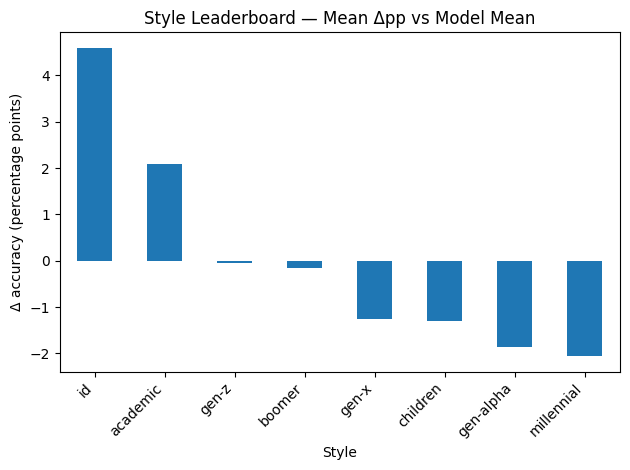

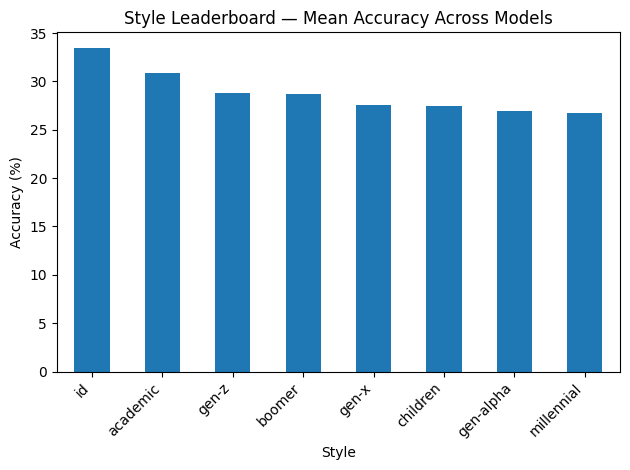

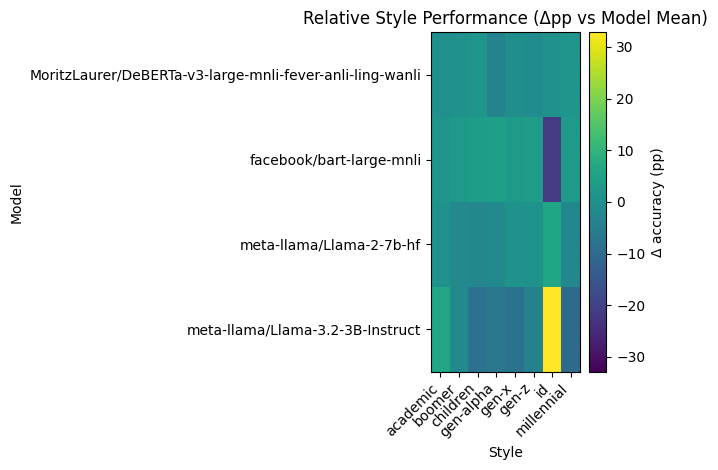

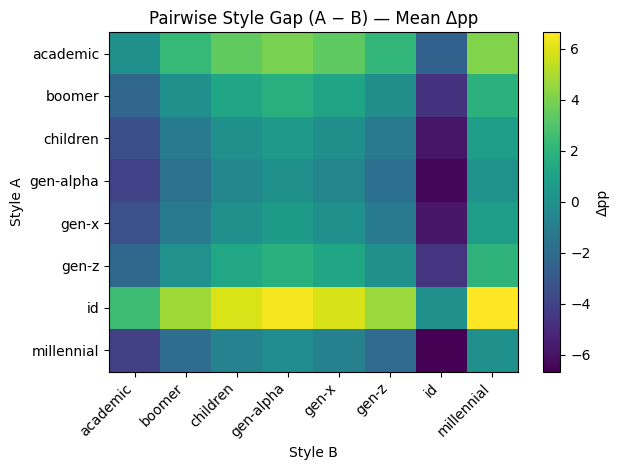

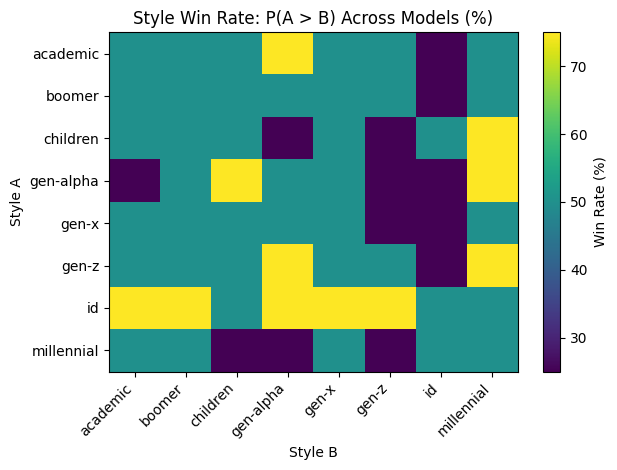

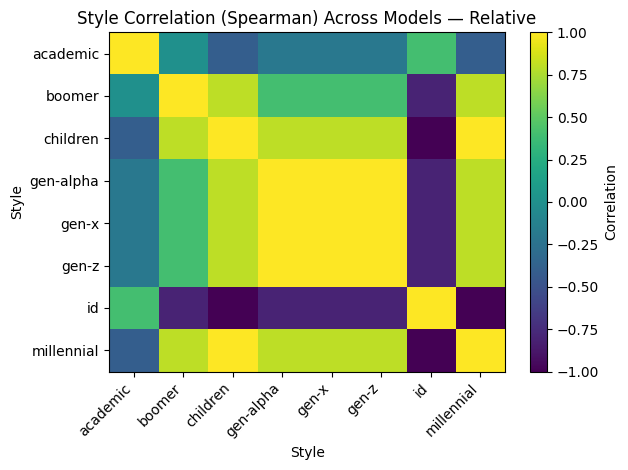

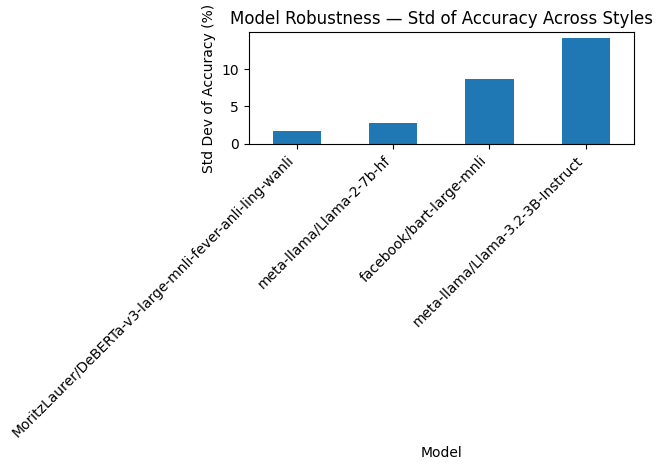

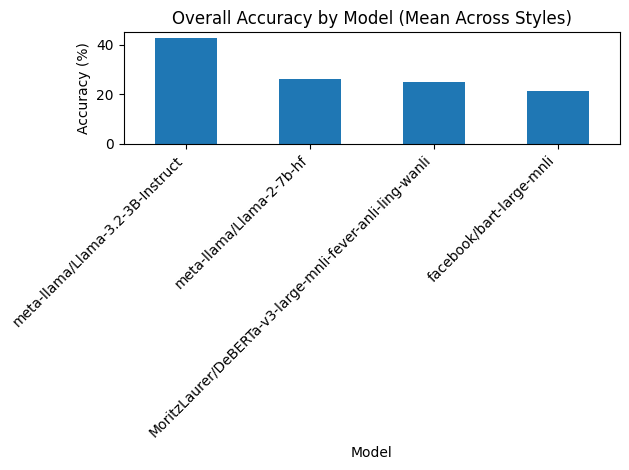

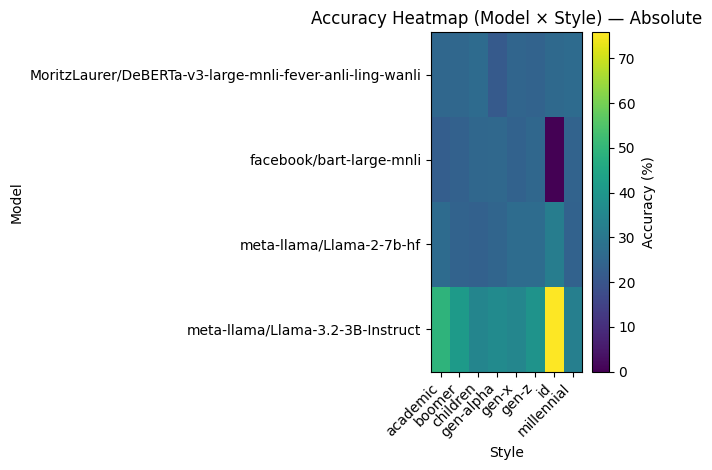

In [6]:

    # df.to_csv(OUTPUT_CSV, index=False)
    # print(f"Saved CSV -> {OUTPUT_CSV}")

    # Model x Style accuracy pivot
    pivot = df.pivot_table(index="model", columns="style", values="accuracy_%", aggfunc="mean")
    pivot = pivot.sort_index()

    # =========================
    # Per-model normalization (center rows by their mean)
    # =========================
    row_mean = pivot.mean(axis=1)
    norm_pivot_pp = pivot.sub(row_mean, axis=0)  # Δpp vs model mean (percentage points)

    # Optional z-score per model (not plotted by default)
    row_std = pivot.std(axis=1).replace(0, np.nan)
    norm_pivot_z = pivot.sub(row_mean, axis=0).div(row_std, axis=0)

    # =========================
    # Style-focused summaries
    # =========================
    # Absolute difficulty by style (mean across models)
    style_mean_abs  = pivot.mean(axis=0).sort_values(ascending=False)
    style_std_abs   = pivot.std(axis=0).sort_values(ascending=False)
    style_count     = pivot.count(axis=0)

    # Relative (mean-centered) style preference across models
    style_mean_rel = norm_pivot_pp.mean(axis=0).sort_values(ascending=False)

    # Model robustness to style (translation doesn’t affect std/range)
    model_std   = pivot.std(axis=1).sort_values(ascending=True)               # lower = more robust
    model_range = (pivot.max(axis=1) - pivot.min(axis=1)).sort_values(ascending=True)   # lower = tighter spread

    # =========================
    # Pairwise style gap/win-rate on relative table (Δpp)
    # =========================
    styles = list(norm_pivot_pp.columns)
    gap_rel = pd.DataFrame(index=styles, columns=styles, dtype=float)
    winrate_rel = pd.DataFrame(index=styles, columns=styles, dtype=float)

    for a in styles:
        for b in styles:
            if a == b:
                gap_rel.loc[a, b] = 0.0
                winrate_rel.loc[a, b] = 50.0
                continue
            common = norm_pivot_pp[[a, b]].dropna()
            if common.empty:
                gap_rel.loc[a, b] = np.nan
                winrate_rel.loc[a, b] = np.nan
                continue
            diff = common[a].to_numpy() - common[b].to_numpy()
            gap_rel.loc[a, b] = float(np.nanmean(diff))
            winrate_rel.loc[a, b] = float((diff > 0).mean() * 100.0)

    # Style correlation (Spearman) using relative table
    style_corr = norm_pivot_pp.corr(method="spearman")

    # Best/Worst style per model (absolute values for interpretability)
    best_worst = []
    for m, row in pivot.iterrows():
        r = row.dropna()
        if r.empty:
            continue
        best = r.idxmax()
        worst = r.idxmin()
        best_worst.append({
            "model": m,
            "best_style": best,
            "best_acc_%": float(r[best]),
            "worst_style": worst,
            "worst_acc_%": float(r[worst]),
            "range_%": float(r[best] - r[worst]),
        })
    best_worst_df = pd.DataFrame(best_worst).sort_values("range_%", ascending=False)
    # best_worst_df.to_csv("best_worst_style_per_model.csv", index=False)
    # print("Saved CSV -> best_worst_style_per_model.csv")

    # # Save extra matrices (optional but handy)
    # norm_pivot_pp.to_csv("pivot_relative_dpp.csv")
    # gap_rel.to_csv("pairwise_gap_relative.csv")
    # winrate_rel.to_csv("pairwise_winrate_relative.csv")
    # style_corr.to_csv("style_corr_spearman_relative.csv")

    # =========================
    # Quick textual insights
    # =========================
    def top_n(s: pd.Series, n=3, title=""):
        n = min(n, len(s))
        if n == 0: return
        print(f"\nTop {n} {title}:")
        for k, v in s.head(n).items():
            print(f"  {k}: {v:.2f}")

    top_n(style_mean_abs, 5, "easiest styles (highest mean accuracy, absolute)")
    top_n(style_mean_rel, 5, "styles that outperform model means (highest mean Δpp)")
    top_n(style_std_abs, 5, "most volatile styles across models (highest std, absolute)")

    print("\nMost robust models (lowest std across styles):")
    print(model_std.head(min(5, len(model_std))))

    print("\nSmallest spread across styles (min range):")
    print(model_range.head(min(5, len(model_range))))

    # =========================
    # Plots (no explicit colors; one chart per figure)
    # =========================

    # A) Relative style leaderboard (Δpp vs model mean)
    plt.figure()
    style_mean_rel.plot(kind="bar")
    plt.title("Style Leaderboard — Mean Δpp vs Model Mean")
    plt.ylabel("Δ accuracy (percentage points)")
    plt.xlabel("Style")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # B) Absolute style leaderboard (mean accuracy)
    plt.figure()
    style_mean_abs.plot(kind="bar")
    plt.title("Style Leaderboard — Mean Accuracy Across Models")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Style")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # C) Relative heatmap (Δpp vs model mean), symmetric around zero
    if norm_pivot_pp.shape[0] > 0 and norm_pivot_pp.shape[1] > 0:
        plt.figure()
        arr = norm_pivot_pp.to_numpy()
        lim = np.nanmax(np.abs(arr)) if np.isfinite(arr).any() else 1.0
        plt.imshow(arr, aspect="auto", interpolation="nearest", vmin=-lim, vmax=lim)
        plt.title("Relative Style Performance (Δpp vs Model Mean)")
        plt.ylabel("Model")
        plt.xlabel("Style")
        plt.yticks(ticks=np.arange(len(norm_pivot_pp.index)), labels=norm_pivot_pp.index)
        plt.xticks(ticks=np.arange(len(norm_pivot_pp.columns)), labels=norm_pivot_pp.columns, rotation=45, ha="right")
        plt.colorbar(label="Δ accuracy (pp)")
        plt.tight_layout()
        plt.show()

    # D) Pairwise style gap heatmap (relative, A − B in Δpp)
    if gap_rel.shape[0] > 0 and gap_rel.shape[1] > 0:
        plt.figure()
        plt.imshow(gap_rel.to_numpy(), aspect="auto", interpolation="nearest")
        plt.title("Pairwise Style Gap (A − B) — Mean Δpp")
        plt.ylabel("Style A")
        plt.xlabel("Style B")
        plt.yticks(ticks=np.arange(len(gap_rel.index)), labels=gap_rel.index)
        plt.xticks(ticks=np.arange(len(gap_rel.columns)), labels=gap_rel.columns, rotation=45, ha="right")
        plt.colorbar(label="Δpp")
        plt.tight_layout()
        plt.show()

    # E) Style win-rate heatmap (relative)
    if winrate_rel.shape[0] > 0 and winrate_rel.shape[1] > 0:
        plt.figure()
        plt.imshow(winrate_rel.to_numpy(), aspect="auto", interpolation="nearest")
        plt.title("Style Win Rate: P(A > B) Across Models (%)")
        plt.ylabel("Style A")
        plt.xlabel("Style B")
        plt.yticks(ticks=np.arange(len(winrate_rel.index)), labels=winrate_rel.index)
        plt.xticks(ticks=np.arange(len(winrate_rel.columns)), labels=winrate_rel.columns, rotation=45, ha="right")
        plt.colorbar(label="Win Rate (%)")
        plt.tight_layout()
        plt.show()

    # F) Style correlation heatmap (Spearman, relative)
    if style_corr.shape[0] > 0 and style_corr.shape[1] > 0:
        plt.figure()
        plt.imshow(style_corr.to_numpy(), aspect="auto", interpolation="nearest", vmin=-1, vmax=1)
        plt.title("Style Correlation (Spearman) Across Models — Relative")
        plt.ylabel("Style")
        plt.xlabel("Style")
        plt.yticks(ticks=np.arange(len(style_corr.index)), labels=style_corr.index)
        plt.xticks(ticks=np.arange(len(style_corr.columns)), labels=style_corr.columns, rotation=45, ha="right")
        plt.colorbar(label="Correlation")
        plt.tight_layout()
        plt.show()

    # G) Model robustness — std across styles (lower is better)
    if len(model_std) > 0:
        plt.figure()
        model_std.plot(kind="bar")
        plt.title("Model Robustness — Std of Accuracy Across Styles")
        plt.ylabel("Std Dev of Accuracy (%)")
        plt.xlabel("Model")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # H) Overall model chart (absolute mean across styles)
    overall = pivot.mean(axis=1).sort_values(ascending=False)
    plt.figure()
    overall.plot(kind="bar")
    plt.title("Overall Accuracy by Model (Mean Across Styles)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Model")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # I) Absolute accuracy heatmap (Model × Style)
    if pivot.shape[0] > 0 and pivot.shape[1] > 0:
        plt.figure()
        arr = pivot.to_numpy()
        plt.imshow(arr, aspect="auto", interpolation="nearest")
        plt.title("Accuracy Heatmap (Model × Style) — Absolute")
        plt.ylabel("Model")
        plt.xlabel("Style")
        plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
        plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns, rotation=45, ha="right")
        plt.colorbar(label="Accuracy (%)")
        plt.tight_layout()
        plt.show()


In [10]:
# Base dataframe
df = pd.DataFrame(records)

# Pivot to wide format: rows = models, columns = styles
df_pivot = df.pivot_table(
    index="model",
    columns="style",
    values="accuracy_%",
    aggfunc="mean"  # or np.mean; handles multiple files per (model, style)
).reset_index()

# Optional: order columns (model first, then styles alphabetically)
df_pivot = df_pivot[["model"] + sorted(c for c in df_pivot.columns if c != "model")]

print(df_pivot)

# Save to CSV
df_pivot.to_csv("results.csv", index=False)


style                                              model  academic  boomer  \
0      MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...      25.2    25.4   
1                               facebook/bart-large-mnli      22.6    23.6   
2                               meta-llama/Llama-2-7b-hf      26.6    24.2   
3                       meta-llama/Llama-3.2-3B-Instruct      49.2    41.4   

style  children  gen-alpha  gen-x  gen-z    id  millennial  
0          26.6       21.4   24.8   24.0  25.8        26.4  
1          25.2       25.6   23.8   25.2  24.0        24.0  
2          23.6       24.6   26.8   26.8  32.0        23.8  
3          34.6       36.2   34.8   39.0  75.8        32.8  


In [11]:
# --- Normalize each model row by its mean ---
df_norm = df_pivot.copy()

# numeric style columns (everything except 'model')
num_cols = [c for c in df_norm.columns if c != "model"]

# compute row means
row_means = df_norm[num_cols].mean(axis=1)

# divide each row by its mean
df_norm[num_cols] = df_norm[num_cols].div(row_means, axis=0)

print("\n== Row-normalized dataframe (df_pivot / row mean) ==")
print(df_norm.head(20).to_string(index=False))

# Optionally save
df_norm.to_csv("model_style_summary_normalized.csv", index=False)



== Row-normalized dataframe (df_pivot / row mean) ==
                                                   model  academic   boomer  children  gen-alpha    gen-x    gen-z       id  millennial
MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli  1.010020 1.018036  1.066132   0.857715 0.993988 0.961924 1.034068    1.058116
                                facebook/bart-large-mnli  0.931959 0.973196  1.039175   1.055670 0.981443 1.039175 0.989691    0.989691
                                meta-llama/Llama-2-7b-hf  1.021113 0.928983  0.905950   0.944338 1.028791 1.028791 1.228407    0.913628
                        meta-llama/Llama-3.2-3B-Instruct  1.144852 0.963351  0.805119   0.842350 0.809773 0.907504 1.763816    0.763234


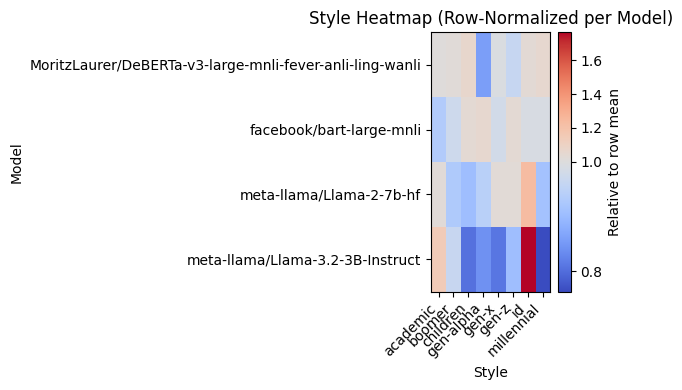

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# numeric styles
styles = [c for c in df_norm.columns if c != "model"]
models = df_norm["model"].tolist()
data = df_norm[styles].to_numpy(dtype=float)

# Mask NaNs
M = np.ma.masked_invalid(data)

plt.figure(figsize=(max(6, len(styles) * 0.7), max(4, len(models) * 0.4)))

# Diverging colormap centered at 1.0 (the mean)
divnorm = colors.TwoSlopeNorm(vmin=np.nanmin(data), vcenter=1.0, vmax=np.nanmax(data))
im = plt.imshow(M, aspect="auto", cmap="coolwarm", norm=divnorm)

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label("Relative to row mean", rotation=90)

# Ticks and labels
plt.xticks(ticks=np.arange(len(styles)), labels=styles, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(models)), labels=models)

plt.title("Style Heatmap (Row-Normalized per Model)")
plt.xlabel("Style")
plt.ylabel("Model")
plt.tight_layout()

plt.savefig("model_style_heatmap_normalized.png", dpi=200)
plt.show()


In [14]:
df_global = df_pivot.copy()
num_cols = [c for c in df_global.columns if c != "model"]
vals = df_global[num_cols].to_numpy(dtype=float)

vmin, vmax = np.nanmin(vals), np.nanmax(vals)
df_global[num_cols] = (df_global[num_cols] - vmin) / (vmax - vmin)

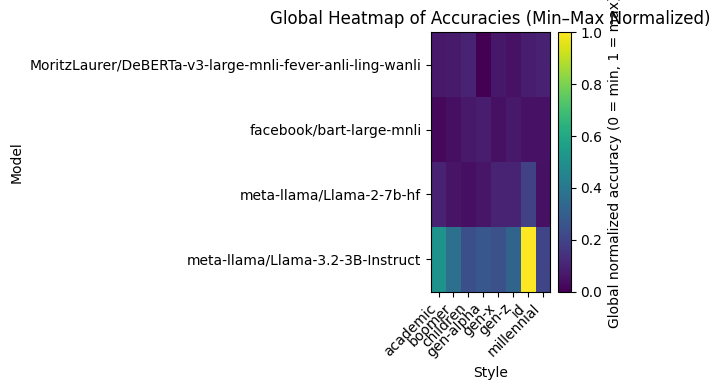

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# numeric style columns
styles = [c for c in df_pivot.columns if c != "model"]
models = df_pivot["model"].tolist()
data = df_pivot[styles].to_numpy(dtype=float)

# --- Global normalization (min-max across all models & styles) ---
vmin, vmax = np.nanmin(data), np.nanmax(data)
norm_data = (data - vmin) / (vmax - vmin)
M = np.ma.masked_invalid(norm_data)

plt.figure(figsize=(max(6, len(styles) * 0.7), max(4, len(models) * 0.4)))

# Sequential colormap to emphasize absolute magnitude
im = plt.imshow(M, aspect="auto", cmap="viridis", vmin=0, vmax=1)

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label("Global normalized accuracy (0 = min, 1 = max)", rotation=90)

# Ticks and labels
plt.xticks(ticks=np.arange(len(styles)), labels=styles, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(models)), labels=models)

plt.title("Global Heatmap of Accuracies (Min–Max Normalized)")
plt.xlabel("Style")
plt.ylabel("Model")
plt.tight_layout()

plt.savefig("model_style_heatmap_global.png", dpi=200)
plt.show()


In [18]:
df_colnorm = df_pivot.copy()
num_cols = [c for c in df_colnorm.columns if c != "model"]
df_colnorm[num_cols] = df_colnorm[num_cols].div(df_colnorm[num_cols].mean(axis=0), axis=1)



/tmp/ipython-input-1421729216.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


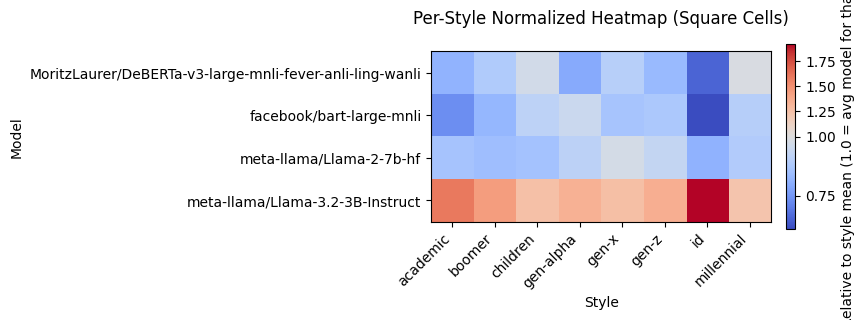

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Column-wise mean normalization
df_colnorm = df_pivot.copy()
num_cols = [c for c in df_colnorm.columns if c != "model"]
df_colnorm[num_cols] = df_colnorm[num_cols].div(df_colnorm[num_cols].mean(axis=0), axis=1)

# Data for plotting
styles = num_cols
models = df_colnorm["model"].tolist()
data = df_colnorm[styles].to_numpy(dtype=float)

# Mask NaNs
M = np.ma.masked_invalid(data)

# Figure size based on grid shape so cells are square
n_rows, n_cols = M.shape
cell_size = 0.6  # tweak for larger/smaller cells
plt.figure(figsize=(n_cols * cell_size, n_rows * cell_size))

# Diverging colormap centered at 1.0
divnorm = colors.TwoSlopeNorm(vmin=np.nanmin(data), vcenter=1.0, vmax=np.nanmax(data))
im = plt.imshow(M, aspect="equal", cmap="coolwarm", norm=divnorm)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Relative to style mean (1.0 = avg model for that style)", rotation=90)

# Axis ticks
plt.xticks(ticks=np.arange(len(styles)), labels=styles, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(models)), labels=models)

plt.title("Per-Style Normalized Heatmap (Square Cells)", pad=20)
plt.xlabel("Style")
plt.ylabel("Model")
plt.tight_layout()

plt.savefig("model_style_heatmap_colnorm.png", dpi=200)
plt.show()



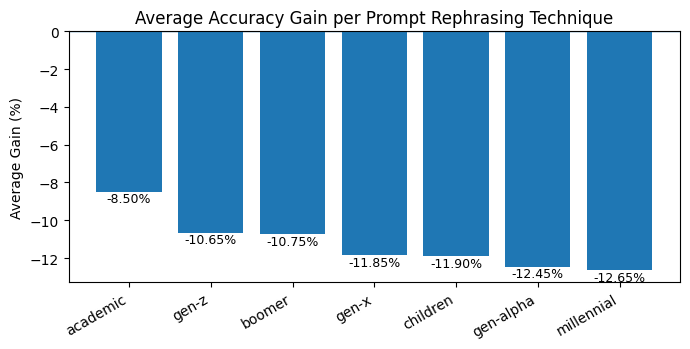

In [26]:
import numpy as np
import matplotlib.pyplot as plt

BASELINE_COL = "id"           # <- change if your baseline differs
IGNORE_COLS  = {"model", "id"}      # styles to skip from plotting

styles = [c for c in df_pivot.columns if c not in IGNORE_COLS and c != BASELINE_COL]
baseline = df_pivot[BASELINE_COL].astype(float)

# gain for each style vs baseline, averaged across models
technique_gain = {
    s: (df_pivot[s].astype(float) - baseline).mean(skipna=True)
    for s in styles
}

# ordered (largest first or keep original order if you prefer)
technique_items = sorted(technique_gain.items(), key=lambda x: x[1], reverse=True)
labels, gains = zip(*technique_items) if technique_items else ([], [])

plt.figure(figsize=(7, 3.6))
bars = plt.bar(range(len(gains)), gains)  # no custom colors per your style rules
plt.axhline(0, linewidth=1)

# annotations like "+0.65%"
for i, v in enumerate(gains):
    s = f"{v:+.2f}%"
    y = v + (0.02 if v >= 0 else -0.02)  # small offset
    va = "bottom" if v >= 0 else "top"
    plt.text(i, y, s, ha="center", va=va, fontsize=9)

plt.title("Average Accuracy Gain per Prompt Rephrasing Technique")
plt.ylabel("Average Gain (%)")
plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
plt.tight_layout()
plt.savefig("avg_gain_per_technique.png", dpi=200)
plt.show()



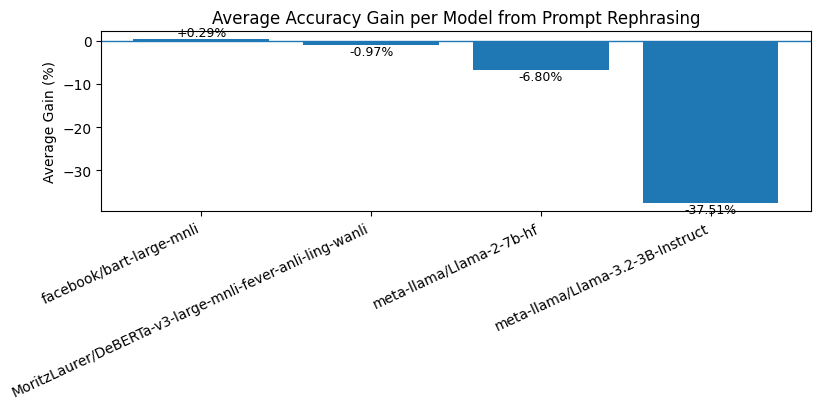

In [27]:
import numpy as np
import matplotlib.pyplot as plt

BASELINE_COL = "id"
IGNORE_COLS  = {"model", "id"}

styles = [c for c in df_pivot.columns if c not in IGNORE_COLS and c != BASELINE_COL]
baseline = df_pivot[BASELINE_COL].astype(float)

# mean gain across styles for each model
model_gains = []
for _, row in df_pivot.iterrows():
    diffs = []
    for s in styles:
        a = row.get(s)
        b = row.get(BASELINE_COL)
        if pd.notna(a) and pd.notna(b):
            diffs.append(float(a) - float(b))
    model_gains.append(np.mean(diffs) if diffs else np.nan)

labels = df_pivot["model"].tolist()
gains  = model_gains

# (optional) sort by gain descending
order = np.argsort(np.array([(-np.inf if pd.isna(g) else -g) for g in gains]))
labels = [labels[i] for i in order]
gains  = [gains[i] for i in order]

plt.figure(figsize=(8.5, 4.2))
bars = plt.bar(range(len(gains)), gains)  # no custom colors
plt.axhline(0, linewidth=1)

for i, v in enumerate(gains):
    if pd.isna(v):
        continue
    s = f"{v:+.2f}%"
    y = v + (0.02 if v >= 0 else -0.02)
    va = "bottom" if v >= 0 else "top"
    plt.text(i, y, s, ha="center", va=va, fontsize=9)

plt.title("Average Accuracy Gain per Model from Prompt Rephrasing")
plt.ylabel("Average Gain (%)")
plt.xticks(range(len(labels)), labels, rotation=25, ha="right")
plt.tight_layout()
plt.savefig("avg_gain_per_model.png", dpi=200)
plt.show()


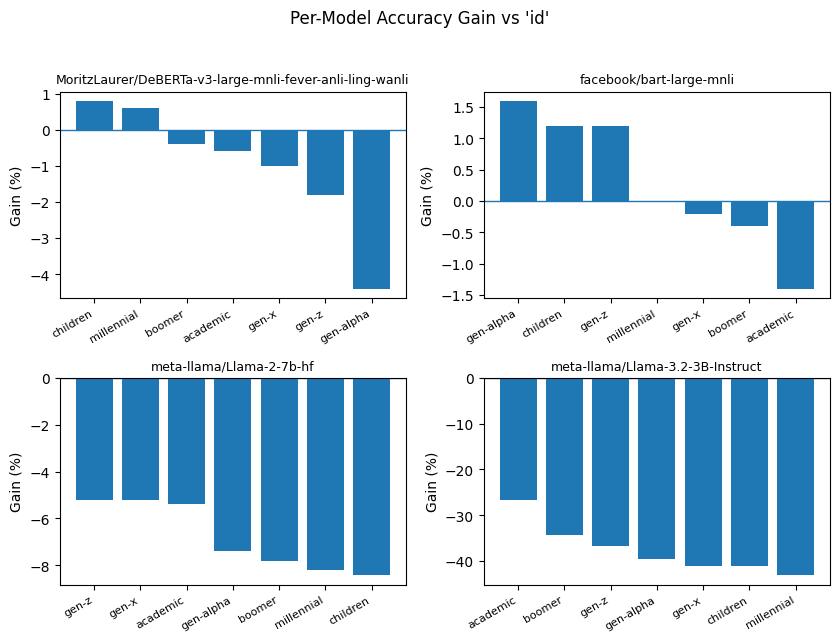

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

BASELINE_COL = "id"
IGNORE_COLS  = {"model", "id"}
styles = [c for c in df_pivot.columns if c not in IGNORE_COLS and c != BASELINE_COL]

models = df_pivot["model"].tolist()
n = len(models)
cols = 2  # tweak grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(8.5, 3.2*rows), squeeze=False)

for idx, model_name in enumerate(models):
    ax = axes[idx // cols][idx % cols]
    r = df_pivot[df_pivot["model"] == model_name].iloc[0]
    baseline = r[BASELINE_COL]

    labs, diffs = [], []
    for s in styles:
        a = r.get(s)
        if pd.notna(a) and pd.notna(baseline):
            labs.append(s)
            diffs.append(float(a) - float(baseline))

    # sort by gain descending (optional)
    order = np.argsort(-np.array(diffs))
    diffs = [diffs[i] for i in order]
    labs  = [labs[i]  for i in order]

    ax.bar(range(len(diffs)), diffs)
    ax.axhline(0, linewidth=1)
    ax.set_title(model_name, fontsize=9)
    ax.set_xticks(range(len(labs)))
    ax.set_xticklabels(labs, rotation=30, ha="right", fontsize=8)
    ax.set_ylabel("Gain (%)")

# hide any empty subplots
for j in range(idx + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols])

fig.suptitle(f"Per-Model Accuracy Gain vs '{BASELINE_COL}'", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig("per_model_gain_small_multiples.png", dpi=200)
plt.show()


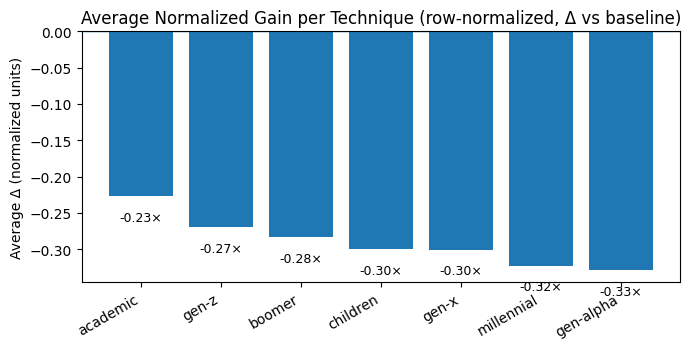

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assumes you've already built df_norm from df_pivot by row-normalizing:
#   num_cols = [c for c in df_pivot.columns if c != "model"]
#   df_norm = df_pivot.copy()
#   df_norm[num_cols] = df_norm[num_cols].div(df_norm[num_cols].mean(axis=1), axis=0)

BASELINE_COL = "id"                 # change if different
IGNORE_COLS  = {"model", BASELINE_COL}

styles = [c for c in df_norm.columns if c not in IGNORE_COLS]

# average normalized delta vs baseline across models
baseline_norm = df_norm[BASELINE_COL].astype(float)
technique_gain_norm = {
    s: (df_norm[s].astype(float) - baseline_norm).mean(skipna=True)
    for s in styles
}

# order bars by gain
items = sorted(technique_gain_norm.items(), key=lambda x: x[1], reverse=True)
labels, gains = zip(*items) if items else ([], [])

plt.figure(figsize=(7, 3.6))
plt.bar(range(len(gains)), gains)        # default colors only
plt.axhline(0, linewidth=1)

# annotate (e.g., +0.12 means +0.12× row mean over baseline)
for i, v in enumerate(gains):
    txt = f"{v:+.2f}×"
    y = v + (0.02 if v >= 0 else -0.02)
    va = "bottom" if v >= 0 else "top"
    plt.text(i, y, txt, ha="center", va=va, fontsize=9)

plt.title("Average Normalized Gain per Technique (row-normalized, Δ vs baseline)")
plt.ylabel("Average Δ (normalized units)")
plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
plt.tight_layout()
plt.savefig("avg_gain_per_technique_normalized.png", dpi=200)
plt.show()
